# IMPORTS AND CONFIGURATION

In [19]:
#imports

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import math
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [2]:
print(torch.cuda.is_available())  # Esto debería devolver True
print(torch.cuda.get_device_name(0))  # Esto debería mostrar "NVIDIA GeForce RTX 4080"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
NVIDIA GeForce RTX 4080 SUPER


# DATA LOADING

In [5]:
path_to_dataset = '../../dataset/swat/SWaT_Dataset_Attack_v0.xlsx'
sheet_name = 'Combined Data'

In [6]:
dfOrig = pd.read_excel(path_to_dataset, 
                       sheet_name = sheet_name, 
                       header = 1)

/home/manuelfrancop/Escritorio/TS-SHAP/ts_shap_entorno/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# DATA PREPROCESSING

In [15]:
df = dfOrig.copy()
df['Normal/Attack'] = df['Normal/Attack'].apply(lambda x: 0 if x == 'Normal' else 1).astype('category')
df['Index'] = df.index
labels = df['Normal/Attack']
data = df.drop(columns=[' Timestamp', 'Normal/Attack'])

In [13]:
data.shape, labels.shape

((449919, 52), (449919,))

In [8]:
segment_size = 500
padding_size = 50
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [22]:
train_data_list, val_data_list, test_data_list, padding_data_list = [], [], [], []
train_labels_list, val_labels_list, test_labels_list, padding_labels_list = [], [], [], []
train_indexes_list, val_indexes_list, test_indexes_list, padding_indexes_list = [], [], [], []

for i in range(0, len(df), segment_size):

    init = i
    end = min(i + segment_size, len(df))

    segment_indexes = df['Index'].iloc[init:end]
    
    segment_data = data.iloc[init:end]
    segment_labels = labels.iloc[init:end]
    
    train_split_index = int(train_percentage * len(segment_data))
    val_split_index = int((train_percentage + val_percentage) * len(segment_data))
    
    #TRAIN
    train_data_list.append(segment_data.iloc[:train_split_index])
    train_labels_list.append(segment_labels.iloc[:train_split_index])
    
    # Padding before VALIDATION
    padding_start = max(0, train_split_index - padding_size)
    padding_data_list.append(segment_data.iloc[padding_start:train_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start:train_split_index])
    
    # VALIDATION
    val_data_list.append(segment_data.iloc[train_split_index:val_split_index])
    val_labels_list.append(segment_labels.iloc[train_split_index:val_split_index])
    
    # Padding before TEST
    padding_start_val = max(0, val_split_index - padding_size)
    padding_end_val = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[padding_start_val:val_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start_val:val_split_index])
    
    # TEST
    test_data_list.append(segment_data.iloc[val_split_index:])
    test_labels_list.append(segment_labels.iloc[val_split_index:])
    
    # Padding before next SEGMENT
    padding_end = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[val_split_index:padding_end])
    padding_labels_list.append(segment_labels.iloc[val_split_index:padding_end])

    train_indexes_list.append(segment_indexes.iloc[:train_split_index])
    val_indexes_list.append(segment_indexes.iloc[train_split_index:val_split_index])
    test_indexes_list.append(segment_indexes.iloc[val_split_index:])


# Concatenate
train_data = pd.concat(train_data_list).reset_index(drop=True)
val_data = pd.concat(val_data_list).reset_index(drop=True)
test_data = pd.concat(test_data_list).reset_index(drop=True)
padding_data = pd.concat(padding_data_list).reset_index(drop=True)

train_labels = pd.concat(train_labels_list).reset_index(drop=True)
val_labels = pd.concat(val_labels_list).reset_index(drop=True)
test_labels = pd.concat(test_labels_list).reset_index(drop=True)
padding_labels = pd.concat(padding_labels_list).reset_index(drop=True)

train_indexes = pd.concat(train_indexes_list).reset_index(drop=True)
val_indexes = pd.concat(val_indexes_list).reset_index(drop=True)
test_indexes = pd.concat(test_indexes_list).reset_index(drop=True)


print(f'Train data shape: {train_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Train index shape: {train_indexes.shape}')
print()

print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Validation index shape: {val_indexes.shape}')
print()

print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Test index shape: {test_indexes.shape}')
print()

x_train = train_data.to_numpy()
y_train = train_labels.to_numpy()
x_val = val_data.to_numpy()
y_val = val_labels.to_numpy()
x_test = test_data.to_numpy()
y_test = test_labels.to_numpy()

Train data shape: (314943, 52)
Train labels shape: (314943,)
Train index shape: (314943,)

Validation data shape: (67488, 52)
Validation labels shape: (67488,)
Validation index shape: (67488,)

Test data shape: (67488, 52)
Test labels shape: (67488,)
Test index shape: (67488,)



In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, indexes, stride=1, window_size=10):

        self.x = data.to_numpy(dtype=np.float32)  
        self.labels = labels.to_numpy(dtype=np.float32)  
        self.labels = np.array([[1, 0] if label == 0 else [0, 1] for label in self.labels], dtype=np.float32)
        self.indexes = indexes.to_numpy(dtype=np.int32)  
        self.window_size = window_size
        self.stride = stride

        self.valid_idxs = self._preprocess_windows()
        self.n_idxs = len(self.valid_idxs)

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {}
        item["given"] = torch.from_numpy(self.x[i:i + self.window_size]).to(torch.float32)
        item["label"] = torch.tensor(self.labels[i + self.window_size - 1], dtype=torch.float32).to(device)
        item["answer"] = torch.tensor(self.labels[i + self.window_size-1], dtype=torch.float32).to(device)
        item["indexes"] = self.indexes[i + self.window_size - 1]
        return item

    def _preprocess_windows(self):
        temp_valid_idxs = []
        total_windows = len(self.x) - self.window_size + 1
        print(f"Total windows: {total_windows}")
        
        for L in range(0, total_windows, self.stride):
            window_indices = self.indexes[L:L + self.window_size]
            
            if np.all(np.diff(window_indices) == 1):
                temp_valid_idxs.append(L)
        
        print(f"Valid windows: {len(temp_valid_idxs)}")
        return np.array(temp_valid_idxs, dtype=np.int32)

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd

In [62]:
zero_variance_columns = train_data.columns[train_data.nunique() <= 1].tolist()

#remove Index column from train_data
train_data_trans = train_data.drop(columns=['Index'])
val_data_trans = val_data.drop(columns=['Index'])
test_data_trans = test_data.drop(columns=['Index'])

train_data_trans = train_data_trans.drop(columns=zero_variance_columns)
val_data_trans = val_data_trans.drop(columns=zero_variance_columns)
test_data_trans = test_data_trans.drop(columns=zero_variance_columns)

categorical_columns = [col for col in train_data_trans.columns if train_data_trans[col].nunique() < 10]
continuous_columns = [col for col in train_data_trans.columns if col not in categorical_columns]

print(f"Zero variance columns: {len(zero_variance_columns)}, {zero_variance_columns}")
print(f'Categorical columns: {len(categorical_columns)}, {categorical_columns}')
print(f'Continuous columns: {len(continuous_columns)}, {continuous_columns}')

Zero variance columns: 7, [' P202', 'P301', 'P401', 'P404', 'P502', 'P601', 'P603']
Categorical columns: 19, [' MV101', 'P101', 'P102', ' MV201', ' P201', 'P203', ' P204', 'P205', 'P206', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']
Continuous columns: 25, ['FIT101', 'LIT101', ' AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']


In [63]:
#cambia los tipos a category

for col in categorical_columns:
    train_data_trans[col] = train_data_trans[col].astype('category')
    val_data_trans[col] = val_data_trans[col].astype('category')
    test_data_trans[col] = test_data_trans[col].astype('category')

train_data_trans[categorical_columns].dtypes

 MV101    category
P101      category
P102      category
 MV201    category
 P201     category
P203      category
 P204     category
P205      category
P206      category
MV301     category
MV302     category
 MV303    category
MV304     category
P302      category
P402      category
P403      category
UV401     category
P501      category
P602      category
dtype: object

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns)
    ]
)

# Crear un pipeline para aplicar las transformaciones
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Ajustar el pipeline en los datos de entrenamiento
pipeline.fit(train_data_trans)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['FIT101', 'LIT101',
                                                   ' AIT201', 'AIT202',
                                                   'AIT203', 'FIT201',
                                                   'DPIT301', 'FIT301',
                                                   'LIT301', 'AIT401', 'AIT402',
                                                   'FIT401', 'LIT401', 'AIT501',
                                                   'AIT502', 'AIT503', 'AIT504',
                                                   'FIT501', 'FIT502', 'FIT503',
                                                   'FIT504', 'PIT501', 'PIT502',
                                                   'PIT503', 'FIT601']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [' MV101', 'P101', 'P102',
                                                   ' MV201', ' P201', 'P203',
                                                   ' P204', 'P205', 'P206',
                                                   'MV301', 'MV302', ' MV303',
                                                   'MV304', 'P302', 'P402',
                                                   'P403', 'UV401', 'P501',
                                                   'P602'])]))])

In [65]:
x_train_trans = pipeline.transform(train_data_trans)
x_val_trans = pipeline.transform(val_data_trans)
x_test_trans = pipeline.transform(test_data_trans)

In [66]:
# Recuperar los nombres de las nuevas variables
categorical_feature_names = pipeline.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_columns)
all_feature_names = continuous_columns + list(categorical_feature_names)

# Crear un DataFrame con los datos transformados
x_train_df = pd.DataFrame(x_train_trans, columns=all_feature_names)
x_val_df = pd.DataFrame(x_val_trans, columns=all_feature_names)
x_test_df = pd.DataFrame(x_test_trans, columns=all_feature_names)

In [67]:
# Imprimir resultados
print(f"Train data transformed shape: {x_train_df.shape}")
print(f"Validation data transformed shape: {x_val_df.shape}")
print(f"Test data transformed shape: {x_test_df.shape}")

# Guardar los nombres de las variables para referencia
variable_names = all_feature_names
print("Variables nuevas después de la transformación:")
print(variable_names)

Train data transformed shape: (314943, 69)
Validation data transformed shape: (67488, 69)
Test data transformed shape: (67488, 69)
Variables nuevas después de la transformación:
['FIT101', 'LIT101', ' AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', ' MV101_0', ' MV101_1', ' MV101_2', 'P101_1', 'P101_2', 'P102_1', 'P102_2', ' MV201_0', ' MV201_1', ' MV201_2', ' P201_1', ' P201_2', 'P203_1', 'P203_2', ' P204_1', ' P204_2', 'P205_1', 'P205_2', 'P206_1', 'P206_2', 'MV301_0', 'MV301_1', 'MV301_2', 'MV302_0', 'MV302_1', 'MV302_2', ' MV303_0', ' MV303_1', ' MV303_2', 'MV304_0', 'MV304_1', 'MV304_2', 'P302_1', 'P302_2', 'P402_1', 'P402_2', 'P403_1', 'P403_2', 'UV401_1', 'UV401_2', 'P501_1', 'P501_2', 'P602_1', 'P602_2']


In [70]:
trainDataset = TimeSeriesDataset(data=pd.DataFrame(x_train_df) , labels=train_labels, indexes=train_indexes , stride=1, window_size=10)
valDataset = TimeSeriesDataset(data=pd.DataFrame(x_val_df) , labels=val_labels, indexes=val_indexes , stride=1, window_size=10)
testDataset = TimeSeriesDataset(data=pd.DataFrame(x_test_df) , labels=test_labels, indexes=test_indexes , stride=1, window_size=10)

Total windows: 314934
Valid windows: 306843
Total windows: 67479
Valid windows: 59388
Total windows: 67479
Valid windows: 59388


In [125]:
x_train_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,P402_1,P402_2,P403_1,P403_2,UV401_1,UV401_2,P501_1,P501_2,P602_1,P602_2
0,0.599851,-0.672078,1.470969,-1.170701,0.500734,0.657637,0.507553,0.543890,0.571288,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.615963,-0.671764,1.470969,-1.170701,0.500734,0.657637,0.507553,0.545442,0.571288,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.651945,-0.672078,1.470969,-1.187723,0.500734,0.654918,0.500114,0.545865,0.575259,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.689807,-0.671138,1.470969,-1.187723,0.500734,0.654918,0.500114,0.545865,0.579231,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.719076,-0.667064,1.470969,-1.187723,0.500734,0.655598,0.500114,0.545865,0.582707,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314938,0.640129,-0.702783,-1.200842,0.942370,-1.089687,0.673163,0.588556,0.533869,0.722201,-0.678864,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
314939,0.623750,-0.706229,-1.200842,0.967889,-1.089687,0.673163,0.584424,0.533869,0.720712,-0.678864,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
314940,0.612740,-0.709676,-1.200842,0.967889,-1.089687,0.673163,0.584424,0.533869,0.719719,-0.678864,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
314941,0.598240,-0.712809,-1.200842,0.967889,-1.089687,0.671690,0.588143,0.533869,0.722697,-0.678864,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [71]:
trainDataset[0]['given'][0].shape

torch.Size([69])

In [126]:
# Crear un diccionario para mapear variables continuas y categóricas a sus índices
categorical_map_indices = {}

# Mapear variables continuas: clave es el nombre, valor es la lista con su índice en all_feature_names
for v in continuous_columns:
    categorical_map_indices[v] = [all_feature_names.index(v)]  # Buscar la posición en all_feature_names

# Mapear variables categóricas: el valor es una lista de índices de los nombres generados por el OneHotEncoder
encoder = pipeline.named_steps["preprocessor"].transformers_[1][1]  # Obtener el OneHotEncoder
for v, categories in zip(categorical_columns, encoder.categories_):
    # Crear los nombres completos de las variables categóricas codificadas
    encoded_names = [f"{v}_{category}" for category in categories]
    # Obtener los índices en all_feature_names
    indices = [all_feature_names.index(name) for name in encoded_names]
    categorical_map_indices[v] = indices

# Imprimir el diccionario resultante
print("Categorical map with indices:")
for key, value in categorical_map_indices.items():
    print(f"{key}: {value}")


Categorical map with indices:
FIT101: [0]
LIT101: [1]
 AIT201: [2]
AIT202: [3]
AIT203: [4]
FIT201: [5]
DPIT301: [6]
FIT301: [7]
LIT301: [8]
AIT401: [9]
AIT402: [10]
FIT401: [11]
LIT401: [12]
AIT501: [13]
AIT502: [14]
AIT503: [15]
AIT504: [16]
FIT501: [17]
FIT502: [18]
FIT503: [19]
FIT504: [20]
PIT501: [21]
PIT502: [22]
PIT503: [23]
FIT601: [24]
 MV101: [25, 26, 27]
P101: [28, 29]
P102: [30, 31]
 MV201: [32, 33, 34]
 P201: [35, 36]
P203: [37, 38]
 P204: [39, 40]
P205: [41, 42]
P206: [43, 44]
MV301: [45, 46, 47]
MV302: [48, 49, 50]
 MV303: [51, 52, 53]
MV304: [54, 55, 56]
P302: [57, 58]
P402: [59, 60]
P403: [61, 62]
UV401: [63, 64]
P501: [65, 66]
P602: [67, 68]


# TRAINING MODEL

In [72]:
class StackedLSTM(torch.nn.Module):

    def __init__(self, n_tags, n_classes, hidden_size=64, num_layers=3, bidirectional=True, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_classes)

    def forward(self, x):
        x = x.transpose(0, 1)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return out

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # Calcular la pérdida CE estándar
        ce_loss = self.ce_loss(inputs, targets)

        # Calcular la probabilidad con softmax
        pt = torch.exp(-ce_loss)  # pt es la probabilidad de la clase correcta

        # Aplicar Focal Loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Parámetros del modelo
input_dim = trainDataset[0]['given'].shape[1]
hidden_dim = 32
num_layers = 2
dropout = 0.2
num_classes = 2  # Ahora tenemos 2 clases

# Inicializar el modelo, la función de pérdida y el optimizador
model = StackedLSTM(n_tags=input_dim, n_classes=num_classes, hidden_size=hidden_dim, num_layers=num_layers).to(device)
criterion = FocalLoss(alpha=0.5, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Crear DataLoaders con los datos procesados (train y test)
batch_size = 2048

train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

entrenar = True
if entrenar:

    # Entrenamiento supervisado
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data_batch in train_loader:
            x_batch = data_batch["given"].to(device)
            y_batch = data_batch["label"].to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = model(x_batch)
            
            # Convertir las etiquetas a índices de clase (0 o 1)
            y_batch_indices = torch.argmax(y_batch, dim=1)
            
            # Calcular la pérdida
            loss = criterion(outputs, y_batch_indices)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}')

        # Evaluación en el conjunto de validación
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data_batch in val_loader:
                x_batch = data_batch["given"].to(device)
                y_batch = data_batch["label"].to(device)

                # Forward pass
                outputs = model(x_batch)

                # Convertir las etiquetas y las predicciones a índices de clase
                y_batch_indices = torch.argmax(y_batch, dim=1)
                predicted = torch.argmax(outputs, dim=1)

                # Calcular la pérdida de validación
                loss = criterion(outputs, y_batch_indices)
                val_loss += loss.item()

                # Acumular predicciones y etiquetas
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch_indices.cpu().numpy())

        val_loss /= len(val_loader)

        # Convertir listas a arrays numpy para métricas
        all_preds = np.array(all_preds).reshape(-1)
        all_labels = np.array(all_labels).reshape(-1)

        # Calcular métricas
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f'Validation Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

    #Guardar el modelo
    torch.save(model.state_dict(), 'ADmodel.pt')

else:
    model.load_state_dict(torch.load('ADmodel.pt'))

Epoch [1/5], Training Loss: 0.0068
Validation Loss: 0.0065 | Accuracy: 0.9579 | Precision: 0.9695 | Recall: 0.8292 | F1-score: 0.8832

Epoch [2/5], Training Loss: 0.0009
Validation Loss: 0.0025 | Accuracy: 0.9639 | Precision: 0.9731 | Recall: 0.8542 | F1-score: 0.9023

Epoch [3/5], Training Loss: 0.0003
Validation Loss: 0.0020 | Accuracy: 0.9772 | Precision: 0.9719 | Recall: 0.9177 | F1-score: 0.9426

Epoch [4/5], Training Loss: 0.0001
Validation Loss: 0.0015 | Accuracy: 0.9762 | Precision: 0.9634 | Recall: 0.9213 | F1-score: 0.9410

Epoch [5/5], Training Loss: 0.0001
Validation Loss: 0.0013 | Accuracy: 0.9776 | Precision: 0.9659 | Recall: 0.9257 | F1-score: 0.9446



Test Accuracy: 0.9761 | Precision: 0.9702 | Recall: 0.9175 | F1-score: 0.9417

[[51775   239]
 [ 1183  6191]]


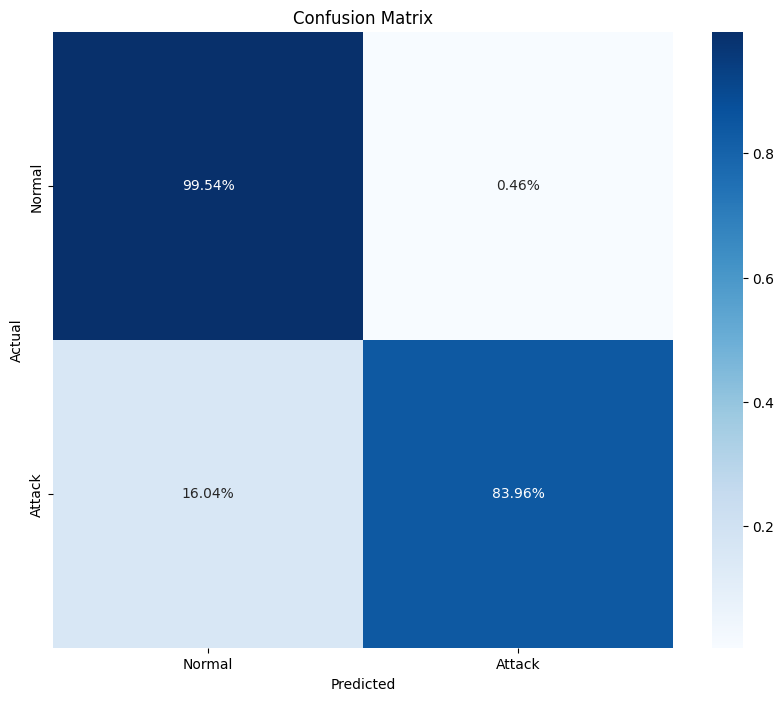

In [ ]:
#predict in the test set and plot confusion matrix
model.eval()
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for data_batch in test_loader:
        x_batch = data_batch["given"].to(device)
        y_batch = data_batch["label"].to(device)

        # Forward pass
        outputs = model(x_batch)

        # Convertir las etiquetas y las predicciones a índices de clase
        y_batch_indices = torch.argmax(y_batch, dim=1)
        predicted = torch.argmax(outputs, dim=1)

        # Acumular predicciones y etiquetas
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch_indices.cpu().numpy())

# Convertir listas a arrays numpy para métricas
all_preds = np.array(all_preds).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

# Calcular métricas
accuracy = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f'Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

#plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print(cm)

#plot cm as heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
#normalize
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# TSG SHAP

In [106]:
import ts_shap
from ts_shap import StrategySubsets, StrategyGrouping, StrategyPrediction

In [111]:
random_samples = random.sample(range(len(trainDataset)), 50)
support = [trainDataset[idx] for idx in random_samples]

inicio = 190
fin = inicio + 100
test = [testDataset[idx] for idx in range(inicio, fin)]


In [ ]:
categorical_map_indices_array = []
for key, value in categorical_map_indices.items():
    categorical_map_indices_array.append(value)

print(categorical_map_indices_array)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25, 26, 27], [28, 29], [30, 31], [32, 33, 34], [35, 36], [37, 38], [39, 40], [41, 42], [43, 44], [45, 46, 47], [48, 49, 50], [51, 52, 53], [54, 55, 56], [57, 58], [59, 60], [61, 62], [63, 64], [65, 66], [67, 68]]


In [131]:
shapley_class = ts_shap.TSSHAP(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.PROCESS,
                               customGroups=categorical_map_indices_array)

shapley_values = shapley_class.compute_tsshap(test)

He cambiado esto 55 veces


In [132]:
shapley_class.nameInstants = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
shapley_class.nameFeatures = variable_names
shapley_class.nameGroups = list(categorical_map_indices.keys())

/home/manuelfrancop/Escritorio/TS-SHAP/paquete_git/TS-SHAP/ts_shap/ts_shap.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


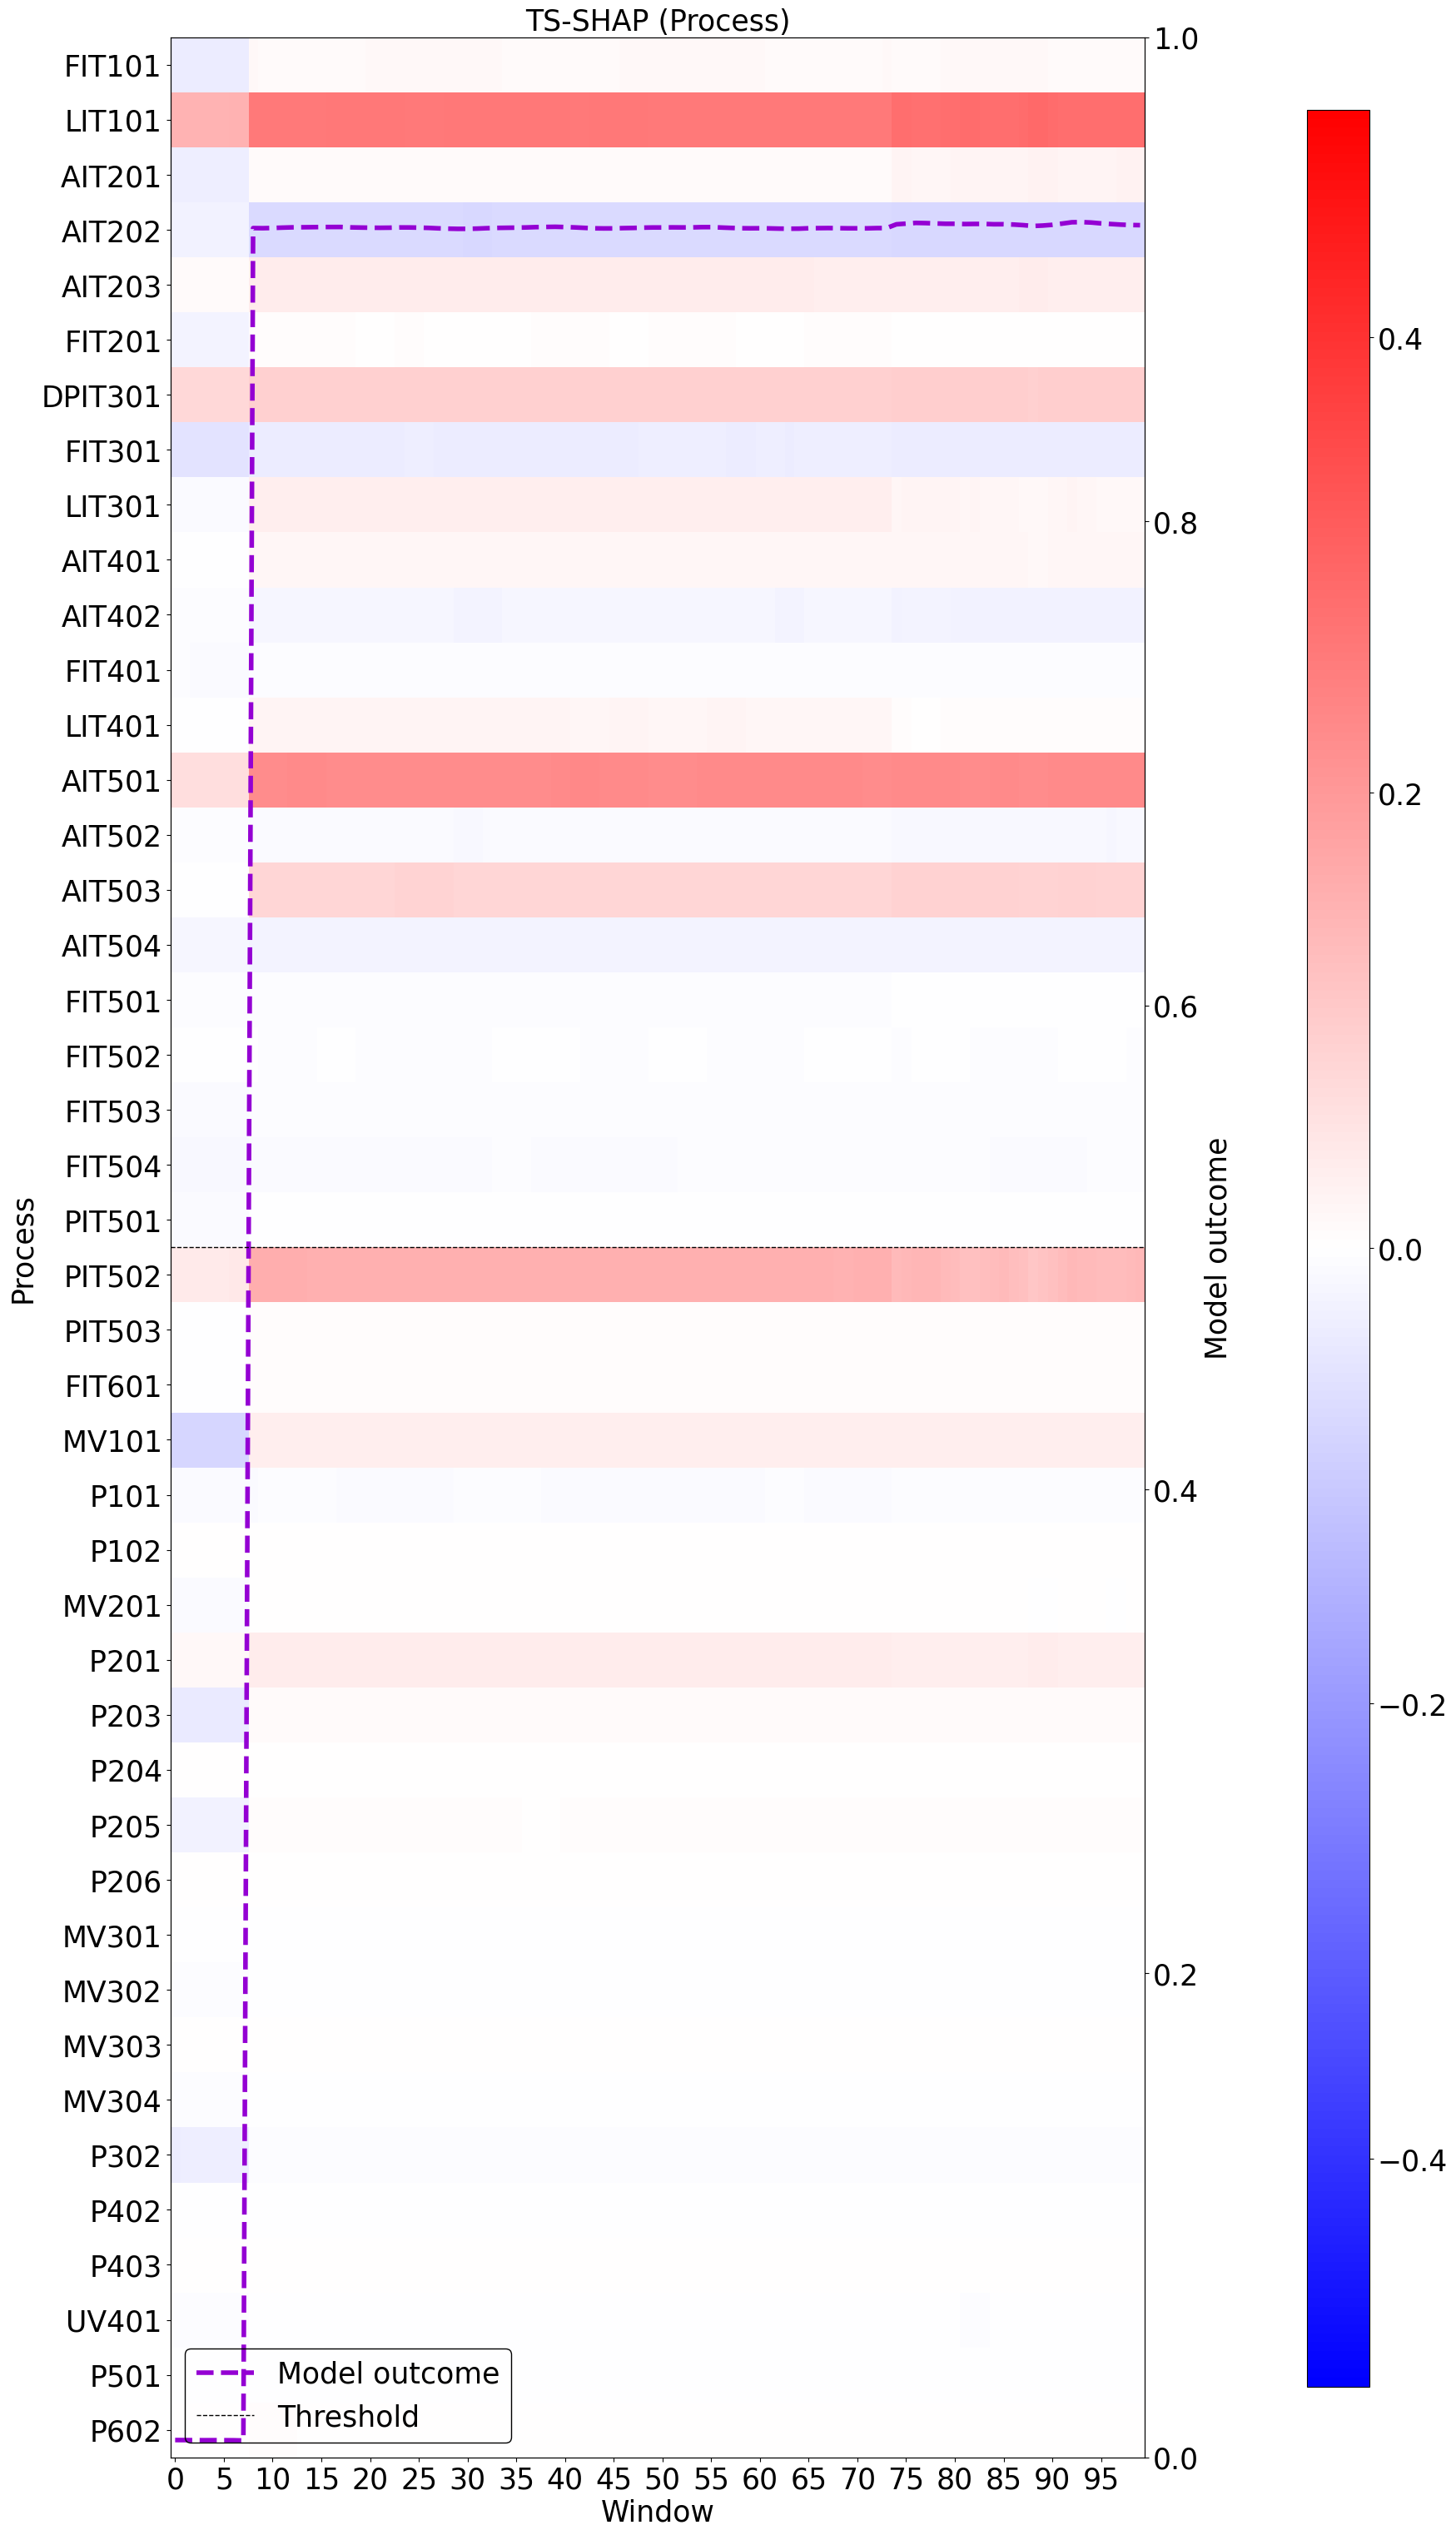

In [133]:
shapley_class.visualize_tsshap(shapley_values, test)